# DS4400 Final Project Source Code

Zach O'Brien

December 2022

# 0. Set up Development Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import TimeSeriesSplit
import sklearn.linear_model as linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from preprocessing import preprocess_bikeshare_data

# 1. Data Preparation

In [2]:
data_file = "data/day.csv"
daily_df = pd.read_csv(data_file)
daily_df.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


### Visualization of the daily ridership counts over the span of the dataset

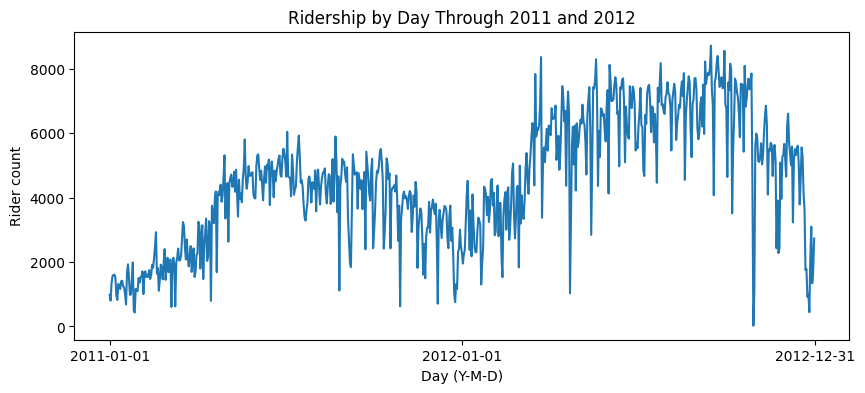

In [3]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(daily_df["cnt"])
ax.set_xlabel("Day (Y-M-D)")
ax.set_ylabel("Rider count")
ax.set_title("Ridership by Day Through 2011 and 2012")
ax.set_xticks([0, len(daily_df)//2, len(daily_df)], labels=daily_df["dteday"][[0, len(daily_df)//2, len(daily_df)-1]])
plt.show()

In [4]:
# Define which columns we want to keep for model training
categorical_columns = ["season", "holiday", "weekday", "workingday", "weathersit"]
continuous_columns = ["temp", "atemp", "hum", "windspeed"]
feature_columns = categorical_columns + continuous_columns
label_column = "cnt"
# Only keep features and target
daily_df = daily_df[feature_columns + [label_column]]

In [5]:
# Preprocess the data by one-hot encoding the categorical features
# and MinMaxScale-ing the label, because it will also be used as a feature (the previous day's count)
preprocessed_daily_df, daily_label_scaler = preprocess_bikeshare_data(daily_df, categorical_cols=categorical_columns, label_col=label_column)
preprocessed_daily_df.describe()

,season_1,season_2,season_3,season_4,holiday_0,holiday_1,weekday_0,weekday_1,weekday_2,weekday_3,...,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,...,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.247606,0.251710,0.257182,0.243502,0.971272,0.028728,0.143639,0.143639,0.142271,0.142271,...,0.316005,0.683995,0.633379,0.337893,0.028728,0.495385,0.474354,0.627894,0.190486,0.515687
std,0.431917,0.434293,0.437380,0.429489,0.167155,0.167155,0.350963,0.350963,0.349567,0.349567,...,0.465233,0.465233,0.482212,0.473316,0.167155,0.183051,0.162961,0.142429,0.077498,0.222873
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.059130,0.079070,0.000000,0.022392,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.337083,0.337842,0.520000,0.134950,0.360101
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.498333,0.486733,0.626667,0.180975,0.520709
75%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.655417,0.608602,0.730209,0.233214,0.682697
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.861667,0.840896,0.972500,0.507463,1.000000


# 2. Non-LSTM Models Training and Evaluation

## 2.1 Create Cross Validation Data for All Models Except LSTM Model

The LSTM model will be trained on hourly data instead of daily data to predict the next day's count. So, its data preparation will be a little different.

In [6]:
X = preprocessed_daily_df.iloc[:-1, :].to_numpy()
y = preprocessed_daily_df[[label_column]].iloc[1:, :].to_numpy()

print(f"Inputs have shape: {X.shape}")
print(f"Labels have shape: {y.shape}")

Inputs have shape: (730, 23)
Labels have shape: (730, 1)


In [7]:
timeseries_crossval = TimeSeriesSplit(n_splits=5)
crossval_indices = list(timeseries_crossval.split(X))

## 2.2 Evaluate Naive Baseline Model

In [8]:
def baseline_model(input_vectors, cnt_col):
    """A naive model which simply uses the previous day's count
       as the prediction for today"""
    return input_vectors[:, cnt_col]

In [9]:
# The column with the previous day's count is the last item in the vector
RIDERSHIP_COUNT_IDX = X.shape[1] - 1  

# Record root mean squared error for each cross validation set
rmse_scores_baseline = []
for train_indices, test_indices in crossval_indices:
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    baseline_predictions = baseline_model(X_test, cnt_col=RIDERSHIP_COUNT_IDX)
    rmse_scores_baseline.append(mean_squared_error(y_test, baseline_predictions, squared=False))

# The count was MinMaxScaled to use in model training. But for better interpretability of
# the results, it is transformed back to its original value here
avg_rmse_score_baseline = daily_label_scaler.inverse_transform(np.average(rmse_scores_baseline).reshape(-1, 1))
print("Average RMSE for Naive Baseline Model:")
print(avg_rmse_score_baseline)

Average RMSE for Naive Baseline Model:
[[1116.73745878]]


## 2.3 Train and Evaluate Linear and Ridge Regression Models

In [10]:
def evaluate_linear_model(model, X, y, ts_crossvalidation_indices):
    """Evaluate a linear model using timeseries cross validation
    
    Args:
        model: A class which can be trained with .fit() and has .predict() to make predictions
        X (ndarray): A 2D array of float values, inputs to the model
        y (ndarray): A 1d array of float values, labels for the inputs
        ts_crossvalidation_indices(list[tuple]): A list of indices for training and testing sets
                                                 to perform timeseries cross validation
    
    Returns:
        list[float]: RMSE scores for each cross validation subset
    """
    rmse_scores = []
    for train_indices, test_indices in ts_crossvalidation_indices:
        model = sklearn.base.clone(model)  # Reset the model parameters
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        rmse_scores.append(mean_squared_error(y_test, predictions, squared=False))
    return rmse_scores

### 2.3.1 Linear Regression Model

In [11]:
rmse_scores_linear = evaluate_linear_model(linear_model.LinearRegression(), X, y, crossval_indices)
print(rmse_scores_linear)
# Same as before, the count was MinMaxScaled to use in model training. But for better interpretability of
# the results, it is transformed back to its original value here
avg_rmse_score_linear = daily_label_scaler.inverse_transform(np.average(rmse_scores_linear).reshape(-1, 1))
print("Average RMSE for Linear Regression Model:")
print(avg_rmse_score_linear)

[0.09278528715154358, 3746402742311.8384, 0.19011677760308157, 0.13033042287442495, 0.14625160542211996]
Average RMSE for Linear Regression Model:
[[6.51274653e+15]]


### 2.3.2 Linear Ridge Regression Model

In [12]:
for alpha in [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
    rmse_scores_ridge = evaluate_linear_model(linear_model.Ridge(alpha=alpha), X, y, crossval_indices)
    avg_rmse_score_ridge = daily_label_scaler.inverse_transform(np.average(rmse_scores_ridge).reshape(-1, 1))
    print(f"Average RMSE for Ridge Regression Model (alpha={alpha}):")
    print(avg_rmse_score_ridge)

Average RMSE for Ridge Regression Model (alpha=0.0001):
[[1179.71529171]]
Average RMSE for Ridge Regression Model (alpha=0.001):
[[1184.10163518]]
Average RMSE for Ridge Regression Model (alpha=0.01):
[[1197.62170877]]
Average RMSE for Ridge Regression Model (alpha=0.1):
[[1214.78179292]]
Average RMSE for Ridge Regression Model (alpha=1):
[[1316.25994467]]
Average RMSE for Ridge Regression Model (alpha=10):
[[1639.18498423]]


## 2.4 Train and Evaluate Feedforward Neural Network

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from nn_dataprep import BikeshareDataset

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(23, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    error = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).numpy()
            error += mean_squared_error(y.numpy(), pred, squared=False)   
    error /= num_batches
    return error

In [16]:
rmse_scores_feedforward_nn = []
for train_indices, test_indices in crossval_indices:
    model = NeuralNetwork()  # Reset the model parameters
    learning_rate = .01
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_dataloader = DataLoader(BikeshareDataset(X[train_indices], y[train_indices]), batch_size=64, shuffle=False)
    test_dataloader = DataLoader(BikeshareDataset(X[test_indices], y[test_indices]), batch_size=64, shuffle=False)
    epochs = 1000
    for t in range(epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer)
    rmse_scores_feedforward_nn.append(test_loop(test_dataloader, model, loss_fn))
    
print(rmse_scores_feedforward_nn)
avg_rmse_score_ridge_feedforward_nn = daily_label_scaler.inverse_transform(np.average(rmse_scores_feedforward_nn).reshape(-1, 1))
print(f"Average RMSE for Feedforward Neural Network")
print(avg_rmse_score_ridge_feedforward_nn)


/home/zach/Desktop/ds4400/final-project/env/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[0.23766642063856125, 0.10786804929375648, 0.24707715213298798, 0.1644800379872322, 0.1446484886109829]
Average RMSE for Feedforward Neural Network
[[1589.58507444]]


# 3. LSTM Model Dataprep, Training, and Evaluation

In [30]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress tensorflow debugging info
import keras
from keras.utils import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, SGD

In [74]:
data_file = "data/hour.csv"
hourly_df = pd.read_csv(data_file)
sum(hourly_df["cnt"][0:24])


985

In [75]:
SEQUENCE_LENGTH_HRS = 24

In [76]:
preprocessed_hourly_df, hourly_label_scaler = preprocess_bikeshare_data(hourly_df, categorical_cols=categorical_columns, label_col=label_column)

In [77]:
def forward_fill_missing_hours(data):
    data_copy = data.copy()
    data_copy = data_copy.set_index("hr").reindex(list(range(24))).reset_index()
    data_copy = data_copy.ffill()
    return data_copy

In [78]:
X = hourly_df.iloc[:-SEQUENCE_LENGTH_HRS, :]
y = daily_df[[label_column]].iloc[1:, :]

X = X.groupby("dteday").apply(forward_fill_missing_hours).reset_index(drop=True)
X.head(40)
#X.iloc[600:650]
#a

,hr,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,1.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0
1,1,2.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0
2,2,3.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,5.0,27.0,32.0
3,3,4.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0
4,4,5.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0
5,5,6.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.24,0.2576,0.75,0.0896,0.0,1.0,1.0
6,6,7.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,2.0,0.0,2.0
7,7,8.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.20,0.2576,0.86,0.0000,1.0,2.0,3.0
8,8,9.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,1.0,7.0,8.0
9,9,10.0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.0,0.32,0.3485,0.76,0.0000,8.0,6.0,14.0


In [75]:
hrly_label_scaler.transform(np.array(sum(hourly_df["cnt"][0:24])).reshape(-1, 1))

array([[1.00819672]])

In [74]:
daily_label_scaler.inverse_transform(np.array(sum(preprocessed_hrly_df["cnt"][0:24])).reshape(-1, 1))

array([[8580.41393443]])

In [ ]:
daily_label_scaler.inverse_transform(y[0].reshape(-1, 1))

In [46]:
X = preprocessed_df.iloc[:-SEQUENCE_LENGTH_HRS, :].to_numpy()
y = preprocessed_df[[label_column]].iloc[SEQUENCE_LENGTH_HRS:, :].to_numpy()

X_train = inputs[:train_set_size]
y_train = labels[:train_set_size]
X_test = inputs[train_set_size:]
y_test = labels[:train_set_size]

train_dataset = timeseries_dataset_from_array(
    data=X_train,
    targets=y_train,
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH_HRS,
    batch_size=BATCH_SIZE)

validation_dataset = timeseries_dataset_from_array(
    data=X_test,
    targets=y_test,
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH_HRS,
    batch_size=BATCH_SIZE)

In [44]:

SAMPLING_RATE=1
BATCH_SIZE=64
FEATURE_VEC_SIZE = 24
LEARNING_RATE=0.01

(8000, 24)
(9331, 24)


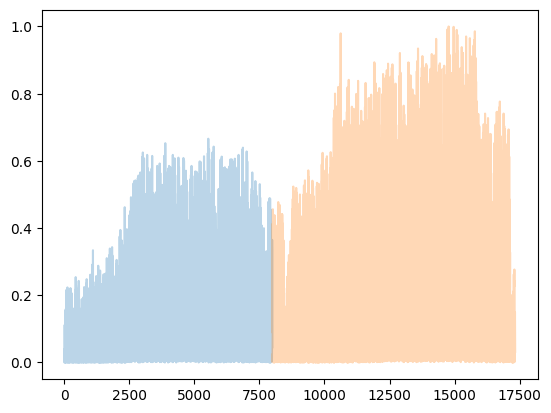

In [48]:
print(X_train.shape)
print(X_test.shape)

fig, ax = plt.subplots()

ax.plot(X_train[:, -1], alpha=0.3)
ax.plot(range(train_set_size, len(X_train) + len(X_test)), X_test[:, -1], alpha=0.3)

In [49]:
model = Sequential()
model.add(keras.Input(shape=(SEQUENCE_LENGTH_HRS, FEATURE_VEC_SIZE)))  # `None` indicates the sequence is of arbitrary length
model.add(LSTM(64))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer=SGD(learning_rate=LEARNING_RATE),
              loss="mean_squared_error", 
              metrics=["mae"])
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                22784     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,849
Trainable params: 22,849
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
125/125 [==============================] - 7s 40ms/step - loss: 0.0360 - mae: 0.1512 - val_loss: 0.0747 - val_mae: 0.2157
Epoch 2/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0306 - mae: 0.1386 - val_loss: 0.0459 - val_mae: 0.1580
Epoch 3/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0267 - mae: 0.1288 - val_loss: 0.0312 - val_mae: 0.1305
Epoch 4/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0248 - mae: 0.1244 - val_loss: 0.0238 - val_mae: 0.1203
Epoch 5/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0234 - mae: 0.1203 - val_loss: 0.0213 - val_mae: 0.1185
Epoch 6/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0224 - mae: 0.1177 - val_loss: 0.0207 - val_mae: 0.1175
Epoch 7/10
125/125 [==============================] - 4s 35ms/step - loss: 0.0219 - mae: 0.1167 - val_loss: 0.0206 - val_mae: 0.1173
Epoch 8/10
125/125 [==============================] - 4s 35ms/step - 

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

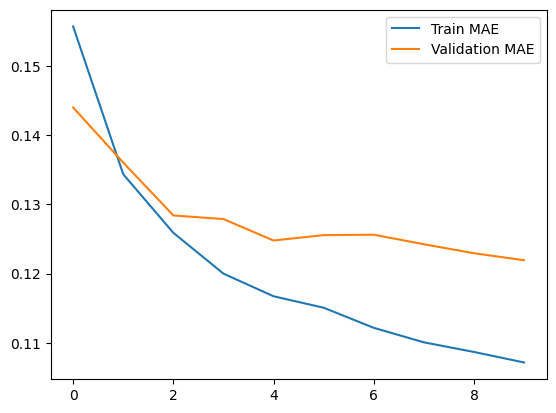

In [30]:
fig, ax = plt.subplots()

ax.plot(history.history["mae"], label="Train MAE")
ax.plot(history.history["val_mae"], label="Validation MAE")
ax.legend()
history.history.keys()